In [1]:
import random
random.seed(11128421)

In [2]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
# 0. Init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.utils import resample
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
import time
import math

In [3]:
def getAggregateMedian(var0,var1,df,toreplace):
    """
    This function calculates the median of var0 when grouped by var1 (aggregate median), 
    with the values in toreplace filtered out in dataframe df.
    To be applied to dataframe.
    @params
    df: dataframe
    var0: numerical variable to get aggregate median
    var1: variable to aggregate by
    toreplace: list of variables to replace by, assumes numerical
    @returns
    meddict: dictionary of values in var0 as keys and aggregate medians as values
    """
    arr = list(df[var1].value_counts().index)
    arrmed = []
    for g in arr:
        for val in toreplace:
            df = df.loc[df[var0] != val]
        med = np.median(df.loc[df[var1] == g,var0])
        arrmed.append(med)
    meddict = dict(zip(arr,arrmed))
    return meddict
def transformToMedian(x,var0, var1,sett,value,cols):
    """
    This function imputes the aggregated median value of var0 by var1
    To be applied to dataframe
    @params
    x: numpy array and changes x based on its var value on set
    sett: dictionary contianing var with associated median value
    var0: name of variable to impute
    var1: name of variable to filter data
    value: list of values to impute
    cols: list of column names to get index of var0 and var1, 
      assumes order of cols is also the order of cols in x
    @returns
    x: ndarray with potential imputation
    """
    for v in range(len(cols)): #getting var name
      if var0 == cols[v]:
        var0=v
    for v in range(len(cols)): #getting var name
      if var1 == cols[v]:
        var1=v
    boolean = False
    for v in value:
      if x[var0] == v:
        boolean = True
    if boolean: #only change value if it is a certain value
        x[var0] = sett[x[var1]]
    return x
def transformToOther(x,sett):
    """
    This function groups rare values together and replaces them with one new value called Other
    To be applied to dataframe
    @params
    x: value
    sett: set of values that will be converted to Other
    @returns
    x or "Other": new or old value
    """
    if x not in sett:
        return "Other"
    return x

In [4]:
df = pd.read_csv("musicData.csv")
df.head(100)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.004680,0.652,-1.0,0.941,0.79200,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.012700,0.622,218293.0,0.890,0.95000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.003060,0.620,215613.0,0.755,0.01180,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.025400,0.774,166875.0,0.700,0.00253,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.004650,0.638,222369.0,0.587,0.90900,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,85035.0,Nightmares On Wax,Ethnic Majority,39.0,0.000307,0.729,271827.0,0.464,0.89000,C#,0.0336,-11.667,Major,0.0354,?,4-Apr,0.576,Electronic
96,49058.0,Trentemøller,Miss You,55.0,0.946000,0.542,247818.0,0.160,0.92800,G,0.2630,-21.672,Minor,0.0365,126.921,4-Apr,0.198,Electronic
97,33015.0,Digitalism,Indigo Skies,27.0,0.010800,0.489,254453.0,0.776,0.13500,A,0.2730,-6.088,Major,0.0351,75.516,4-Apr,0.436,Electronic
98,83258.0,Booka Shade,In White Rooms,51.0,0.000962,0.800,326840.0,0.650,0.82000,C,0.2310,-9.145,Major,0.0587,?,4-Apr,0.096,Electronic


In [5]:
print("Columns of this data: ", df.columns)

Columns of this data:  Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')


In [6]:
print("Null values and data type: ", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [7]:
print(df.isnull().sum())

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64


### Viewing Data 

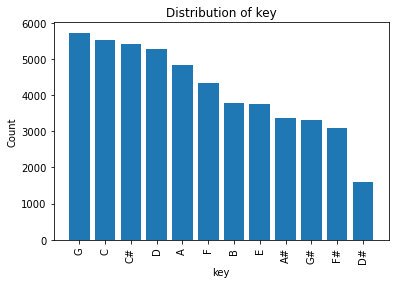

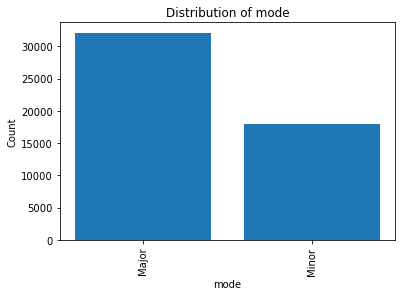

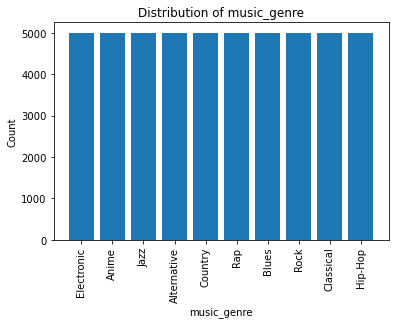

In [8]:
categorical = ['key','mode','music_genre']
for i in categorical : 
    # count the number of songs in each genre
    val_counts = df[i].value_counts()

    # sort the genres by count in descending order
    val_counts = val_counts.sort_values(ascending=False)

    # create a bar chart with genre on the x-axis and count on the y-axis
    plt.bar(val_counts.index, val_counts.values)

    # add labels and title
    plt.xlabel(str(i))
    plt.ylabel('Count')
    plt.title('Distribution of '+ str(i))

    # rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # show the plot
    plt.show()

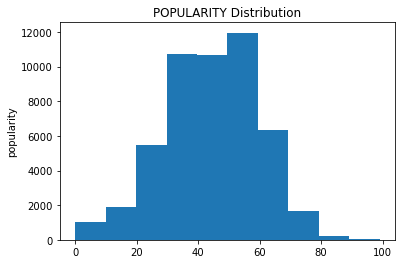

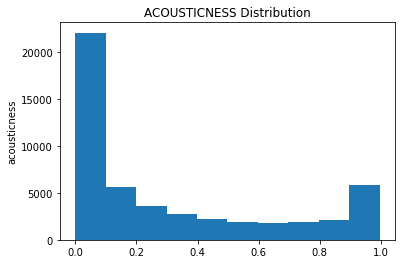

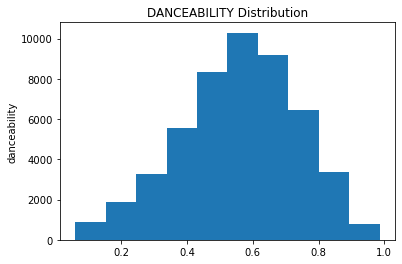

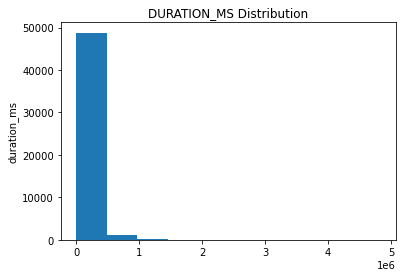

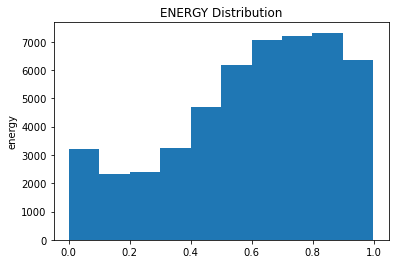

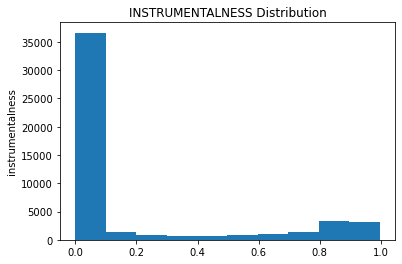

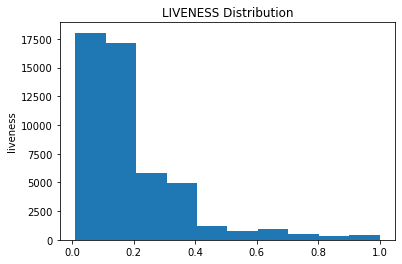

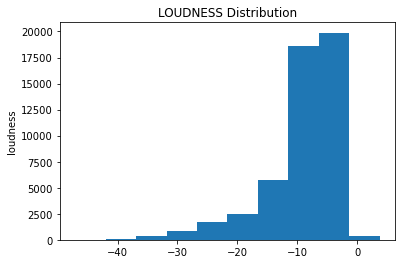

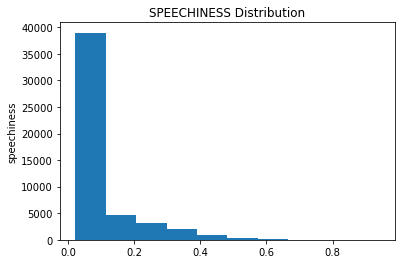

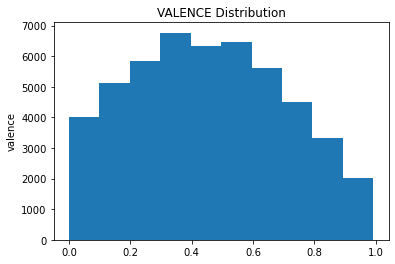

In [9]:
# create a boxplot of the popularity data
numerical = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence']

for i in numerical :       
    plt.hist(df[i])
    plt.title( str(i).upper() + ' Distribution')
    plt.ylabel(str(i))
    plt.show()

### Dropping Nan 

In [10]:
# which rows have null values in it 
df1 = df[df.isna().any(axis=1)]
df1

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#since all null data are all on 1 row, we drop na where all the rows has missing values 
df = df.dropna(how='all')
df.shape

(50000, 18)

### Dropping identification columns 

In [12]:
identification = ['instance_id','track_name','obtained_date']
df = df.drop(columns = identification)
df

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,Röyksopp,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,Thievery Corporation,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,Dillon Francis,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,Dubloadz,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,What So Not,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,BEXEY,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,0.330,Hip-Hop
50001,Roy Woods,72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,0.113,Hip-Hop
50002,Berner,51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
50003,The-Dream,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,0.354,Hip-Hop


### Processing artist name

In [13]:
artistvalcount = pd.DataFrame(df['artist_name'].value_counts(),columns=["artist_name"])
avc = artistvalcount.drop(labels=["empty_field"],axis=0)

In [14]:
mostfreqartists = set(avc.loc[avc["artist_name"] > 100].index)
df["artist_name"] = df["artist_name"].apply(lambda x : transformToOther(x,mostfreqartists))

### Processing - 1 in music duration 

In [15]:
df

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,Other,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,Thievery Corporation,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,Other,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,Other,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,Other,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,Other,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,0.330,Hip-Hop
50001,Other,72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,0.113,Hip-Hop
50002,Other,51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
50003,Other,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,0.354,Hip-Hop


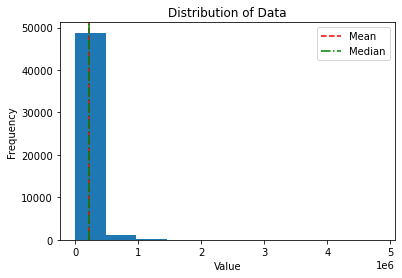

In [16]:
# Compute mean and median
mean = df['duration_ms'].mean()
median = df['duration_ms'].median()
# Create histogram with bar chart
plt.hist(df['duration_ms'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Add mean and median lines
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.axvline(median, color='g', linestyle='-.', label='Median')

# Add legend
plt.legend()

# Display plot
plt.show()

In [17]:
genres = getAggregateMedian("duration_ms","music_genre",df,[-1])
df = df.apply(lambda x : transformToMedian(x,"duration_ms","music_genre",genres,[-1],list(df.columns)),raw=True,axis=1, result_type='broadcast')

### Processing ? in tempo 

In [18]:
#The tempo data should be numerical but is currently object because there's data where tempo = "?":
#casting tempo as float 
numerical = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
df['tempo'] = df['tempo'].replace('?', np.nan)
df['tempo'] = df['tempo'].astype(float)

In [19]:
# show values where the value is non-float
for col in numerical:
    non_float_values = df[col][df[col].apply(lambda x: isinstance(x, float) == False)]
    print(f'Non-float values in {col}: {non_float_values.tolist()}')

Non-float values in popularity: []
Non-float values in acousticness: []
Non-float values in danceability: []
Non-float values in duration_ms: []
Non-float values in energy: []
Non-float values in instrumentalness: []
Non-float values in liveness: []
Non-float values in loudness: []
Non-float values in speechiness: []
Non-float values in tempo: []
Non-float values in valence: []


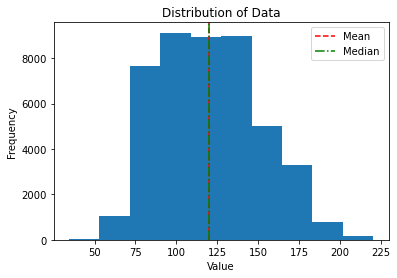

In [20]:
# Compute mean and median
mean = df['tempo'].mean()
median = df['tempo'].median()
# Create histogram with bar chart
plt.hist(df['tempo'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Add mean and median lines
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.axvline(median, color='g', linestyle='-.', label='Median')

# Add legend
plt.legend()

# Display plot
plt.show()

In [21]:
df['tempo']=df['tempo'].fillna(median)

In [22]:
#other way to do it : 

In [23]:
df["tempo"] = df["tempo"].replace(to_replace=["?"],value=[-1])
df["tempo"] = pd.to_numeric(df["tempo"])
genres = getAggregateMedian("tempo","music_genre",df,[-1])
df = df.apply(lambda x : transformToMedian(x,"tempo","music_genre",genres,[-1],list(df.columns)),raw=True,axis=1)

### Encode mode : 

In [24]:
#The variable that needed to be encoded are "key", "mode". 
# dummy code the categorical variable
df_dummies = pd.get_dummies(df['mode'], prefix='mode')

# combine the dummy coded variables with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

# print the resulting DataFrame
df = df.drop('mode', axis=1)
df

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,music_genre,mode_Major,mode_Minor
0,Other,27.0,0.00468,0.652,245217.0,0.941,0.792,A#,0.115,-5.201,0.0748,100.889,0.759,Electronic,0,1
1,Thievery Corporation,31.0,0.0127,0.622,218293.0,0.89,0.95,D,0.124,-7.043,0.03,115.002,0.531,Electronic,0,1
2,Other,28.0,0.00306,0.62,215613.0,0.755,0.0118,G#,0.534,-4.617,0.0345,127.994,0.333,Electronic,1,0
3,Other,34.0,0.0254,0.774,166875.0,0.7,0.00253,C#,0.157,-4.498,0.239,128.014,0.27,Electronic,1,0
4,Other,32.0,0.00465,0.638,222369.0,0.587,0.909,F#,0.157,-6.266,0.0413,145.036,0.323,Electronic,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,Other,59.0,0.0334,0.913,215240.0,0.574,0.0,C#,0.119,-7.022,0.298,98.028,0.33,Hip-Hop,1,0
50001,Other,72.0,0.157,0.709,251860.0,0.362,0.0,B,0.109,-9.814,0.055,122.043,0.113,Hip-Hop,1,0
50002,Other,51.0,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,0.146,131.079,0.395,Hip-Hop,1,0
50003,Other,65.0,0.0831,0.782,262773.0,0.472,0.0,G,0.106,-5.016,0.0441,75.886,0.354,Hip-Hop,0,1


### Categorical variable to dummy variables : key and artist_name and music_genre

In [25]:
#The variable that needed to be encoded are "key", "mode". 
# dummy code the categorical variable
df_dummies = pd.get_dummies(df['key'], prefix='key')

# combine the dummy coded variables with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

# print the resulting DataFrame
df = df.drop('key', axis=1)
df

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,Other,27.0,0.00468,0.652,245217.0,0.941,0.792,0.115,-5.201,0.0748,...,0,0,0,0,0,0,0,0,0,0
1,Thievery Corporation,31.0,0.0127,0.622,218293.0,0.89,0.95,0.124,-7.043,0.03,...,0,0,0,1,0,0,0,0,0,0
2,Other,28.0,0.00306,0.62,215613.0,0.755,0.0118,0.534,-4.617,0.0345,...,0,0,0,0,0,0,0,0,0,1
3,Other,34.0,0.0254,0.774,166875.0,0.7,0.00253,0.157,-4.498,0.239,...,0,0,1,0,0,0,0,0,0,0
4,Other,32.0,0.00465,0.638,222369.0,0.587,0.909,0.157,-6.266,0.0413,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,Other,59.0,0.0334,0.913,215240.0,0.574,0.0,0.119,-7.022,0.298,...,0,0,1,0,0,0,0,0,0,0
50001,Other,72.0,0.157,0.709,251860.0,0.362,0.0,0.109,-9.814,0.055,...,1,0,0,0,0,0,0,0,0,0
50002,Other,51.0,0.00597,0.693,189483.0,0.763,0.0,0.143,-5.443,0.146,...,0,0,0,1,0,0,0,0,0,0
50003,Other,65.0,0.0831,0.782,262773.0,0.472,0.0,0.106,-5.016,0.0441,...,0,0,0,0,0,0,0,0,1,0


In [26]:
#The variable that needed to be encoded are "key", "mode". 
# dummy code the categorical variable
df_dummies = pd.get_dummies(df['artist_name'], prefix='artist_name')

# combine the dummy coded variables with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

# print the resulting DataFrame
df = df.drop('artist_name', axis=1)
df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,artist_name_Johann Sebastian Bach,artist_name_Kevin Gates,artist_name_Ludwig van Beethoven,artist_name_Nobuo Uematsu,artist_name_Other,artist_name_Pyotr Ilyich Tchaikovsky,artist_name_The Black Keys,artist_name_Thievery Corporation,artist_name_Wolfgang Amadeus Mozart,artist_name_Yuki Hayashi
0,27.0,0.00468,0.652,245217.0,0.941,0.792,0.115,-5.201,0.0748,100.889,...,0,0,0,0,1,0,0,0,0,0
1,31.0,0.0127,0.622,218293.0,0.89,0.95,0.124,-7.043,0.03,115.002,...,0,0,0,0,0,0,0,1,0,0
2,28.0,0.00306,0.62,215613.0,0.755,0.0118,0.534,-4.617,0.0345,127.994,...,0,0,0,0,1,0,0,0,0,0
3,34.0,0.0254,0.774,166875.0,0.7,0.00253,0.157,-4.498,0.239,128.014,...,0,0,0,0,1,0,0,0,0,0
4,32.0,0.00465,0.638,222369.0,0.587,0.909,0.157,-6.266,0.0413,145.036,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,59.0,0.0334,0.913,215240.0,0.574,0.0,0.119,-7.022,0.298,98.028,...,0,0,0,0,1,0,0,0,0,0
50001,72.0,0.157,0.709,251860.0,0.362,0.0,0.109,-9.814,0.055,122.043,...,0,0,0,0,1,0,0,0,0,0
50002,51.0,0.00597,0.693,189483.0,0.763,0.0,0.143,-5.443,0.146,131.079,...,0,0,0,0,1,0,0,0,0,0
50003,65.0,0.0831,0.782,262773.0,0.472,0.0,0.106,-5.016,0.0441,75.886,...,0,0,0,0,1,0,0,0,0,0


In [27]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['music_genre'] = enc.fit_transform(df['music_genre'])
df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,artist_name_Johann Sebastian Bach,artist_name_Kevin Gates,artist_name_Ludwig van Beethoven,artist_name_Nobuo Uematsu,artist_name_Other,artist_name_Pyotr Ilyich Tchaikovsky,artist_name_The Black Keys,artist_name_Thievery Corporation,artist_name_Wolfgang Amadeus Mozart,artist_name_Yuki Hayashi
0,27.0,0.00468,0.652,245217.0,0.941,0.792,0.115,-5.201,0.0748,100.889,...,0,0,0,0,1,0,0,0,0,0
1,31.0,0.0127,0.622,218293.0,0.89,0.95,0.124,-7.043,0.03,115.002,...,0,0,0,0,0,0,0,1,0,0
2,28.0,0.00306,0.62,215613.0,0.755,0.0118,0.534,-4.617,0.0345,127.994,...,0,0,0,0,1,0,0,0,0,0
3,34.0,0.0254,0.774,166875.0,0.7,0.00253,0.157,-4.498,0.239,128.014,...,0,0,0,0,1,0,0,0,0,0
4,32.0,0.00465,0.638,222369.0,0.587,0.909,0.157,-6.266,0.0413,145.036,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,59.0,0.0334,0.913,215240.0,0.574,0.0,0.119,-7.022,0.298,98.028,...,0,0,0,0,1,0,0,0,0,0
50001,72.0,0.157,0.709,251860.0,0.362,0.0,0.109,-9.814,0.055,122.043,...,0,0,0,0,1,0,0,0,0,0
50002,51.0,0.00597,0.693,189483.0,0.763,0.0,0.143,-5.443,0.146,131.079,...,0,0,0,0,1,0,0,0,0,0
50003,65.0,0.0831,0.782,262773.0,0.472,0.0,0.106,-5.016,0.0441,75.886,...,0,0,0,0,1,0,0,0,0,0


### Splitting data 

In [28]:
#splitting train and test set 
import pandas as pd
from sklearn.model_selection import train_test_split

# group the songs by their genre
genre_groups = df.groupby('music_genre')
# initialize the train and test sets as empty dataframes
train_set = pd.DataFrame()
test_set = pd.DataFrame()

# for each genre, split the songs into train and test sets
for genre, group in genre_groups:
    # randomly select 500 songs for the test set
    test = group.sample(n=500, random_state = 11128421)
    # select the remaining 4500 songs for the train set
    train = group.drop(test.index)
    # add the train and test sets to the overall train and test dataframes
    train_set = pd.concat([train_set, train])
    test_set = pd.concat([test_set, test])

# verify that the train and test sets have the correct sizes
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")


Train set size: 45000
Test set size: 5000


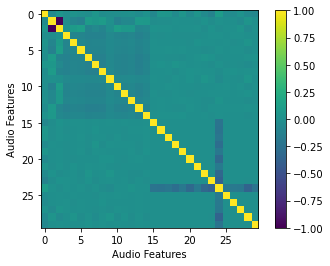

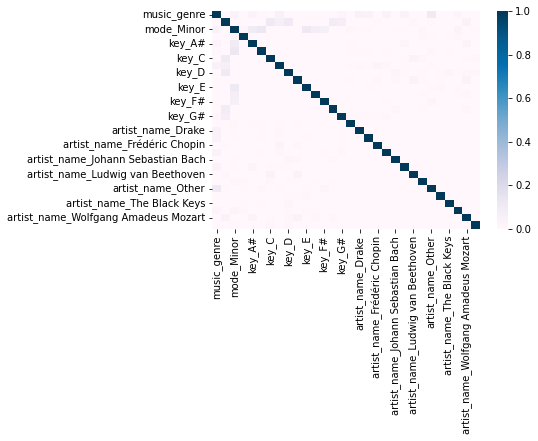

In [29]:
import seaborn as sns
#Check correlation matrix : 
corrMatrix = df.corr()
# Plot the data:
plt.imshow(corrMatrix) 
plt.xlabel('Audio Features')
plt.ylabel('Audio Features')
plt.colorbar()
plt.show()


sns.heatmap(corrMatrix, vmin=0, vmax=1, cmap= "PuBu")
plt.show()

In [30]:
test_set['music_genre'].value_counts()

0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: music_genre, dtype: int64

In [31]:
train_set['music_genre'].value_counts()

0    4500
1    4500
2    4500
3    4500
4    4500
5    4500
6    4500
7    4500
8    4500
9    4500
Name: music_genre, dtype: int64

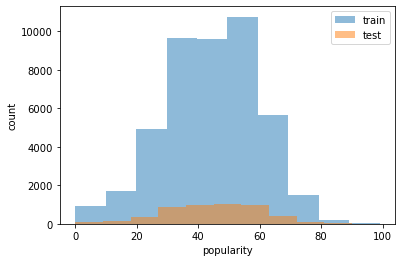

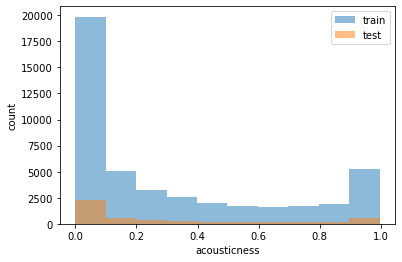

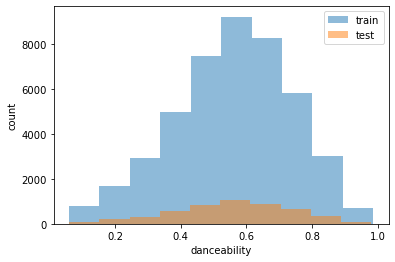

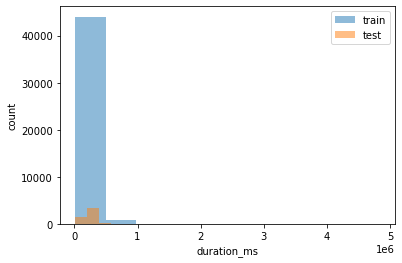

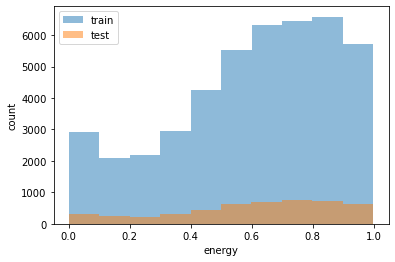

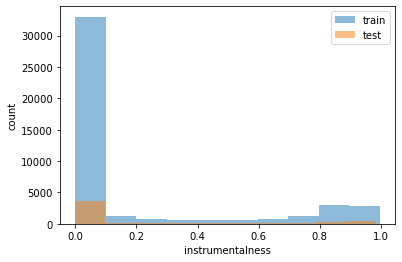

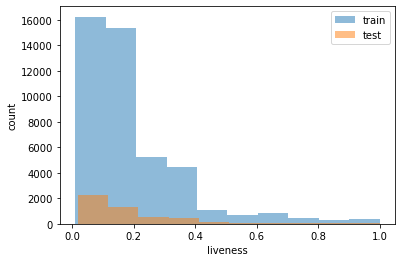

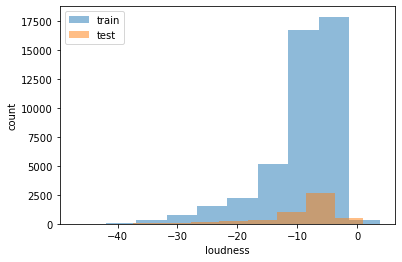

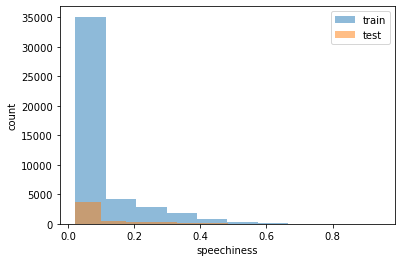

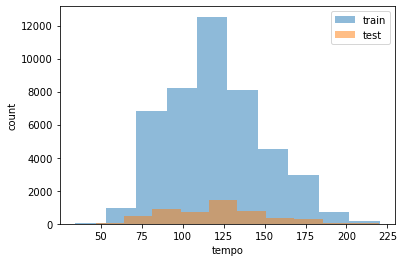

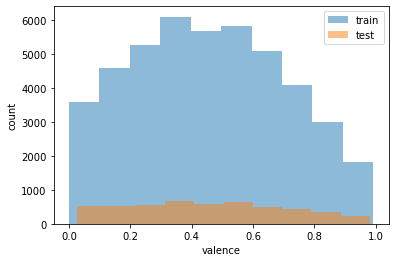

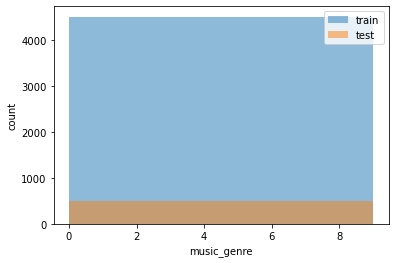

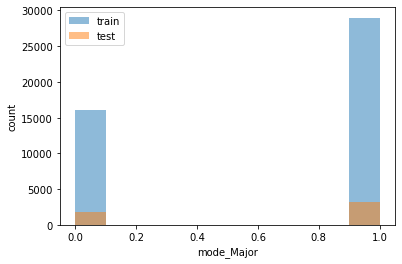

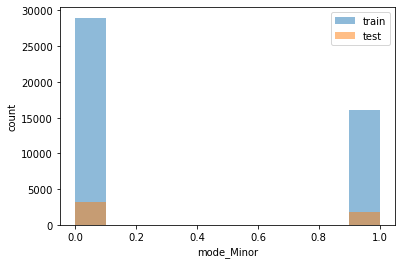

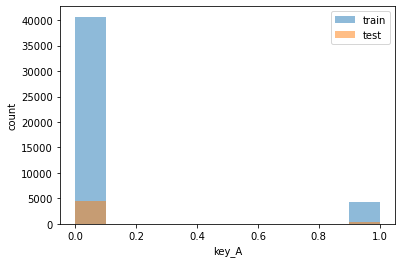

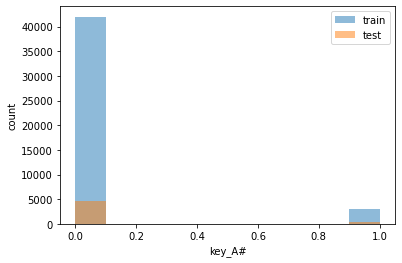

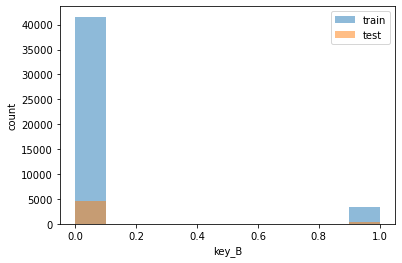

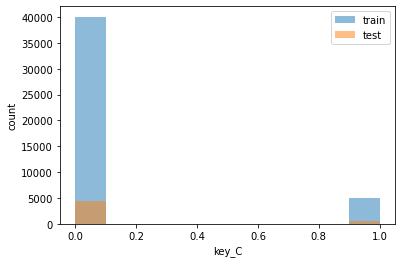

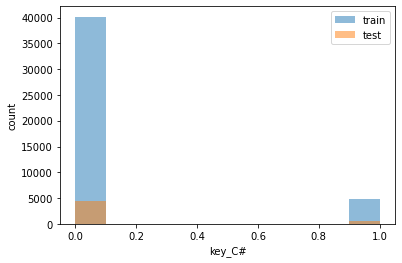

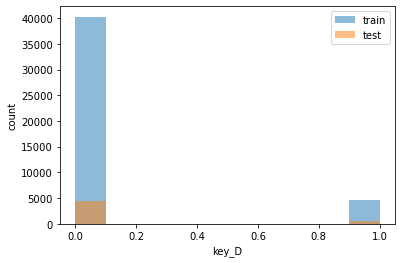

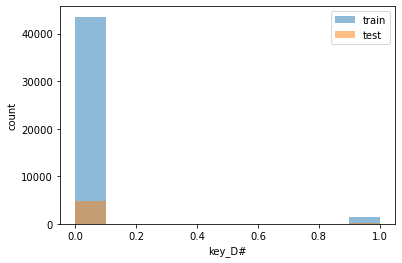

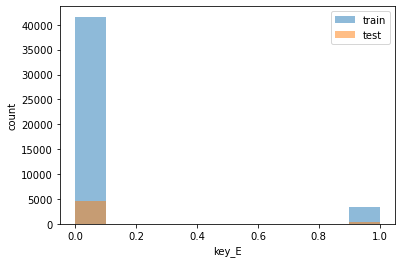

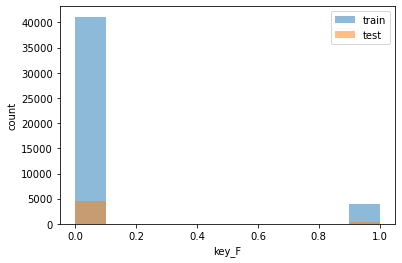

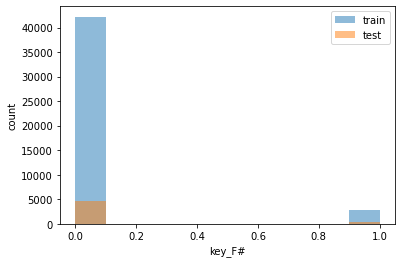

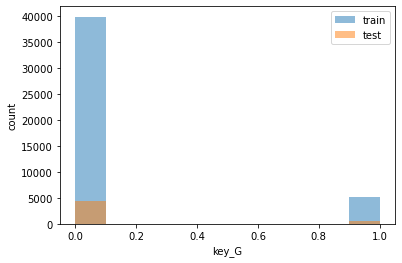

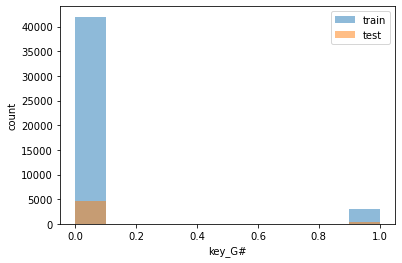

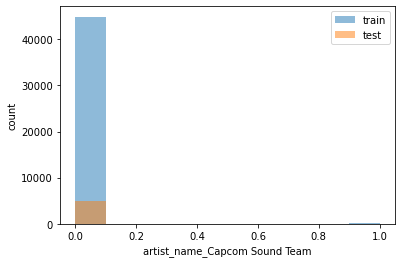

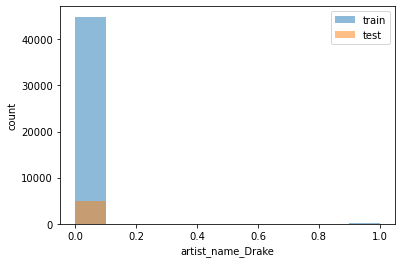

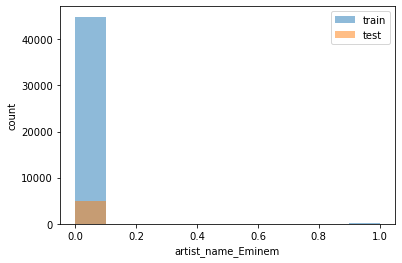

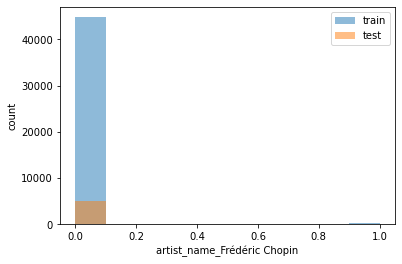

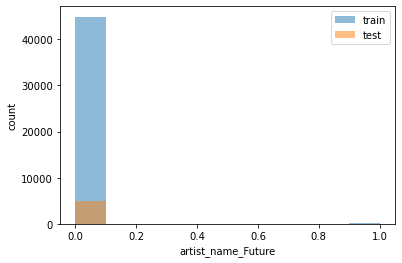

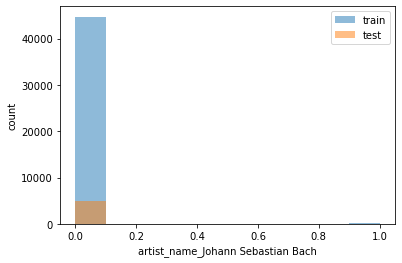

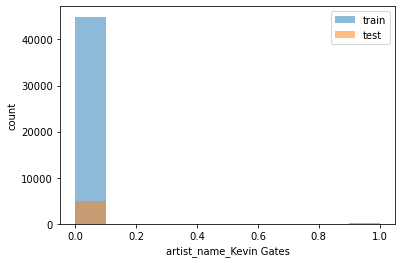

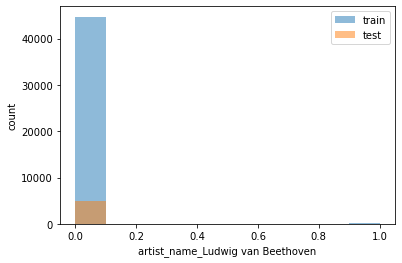

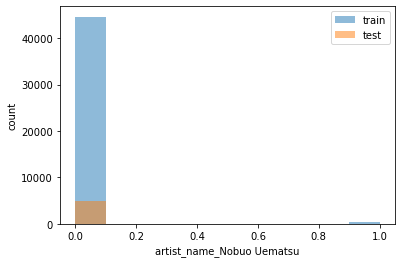

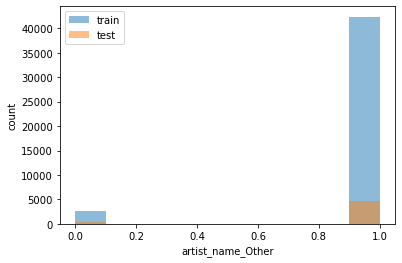

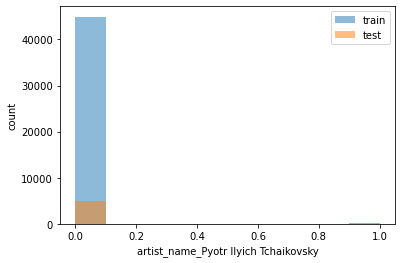

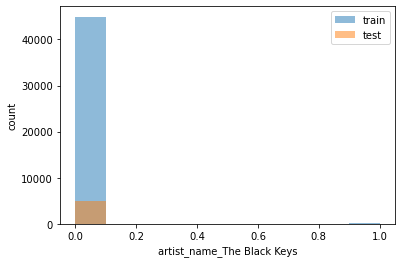

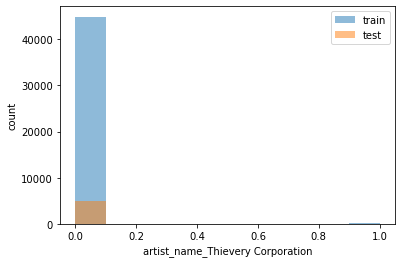

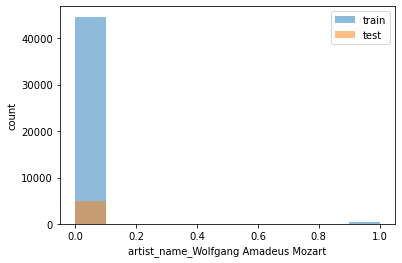

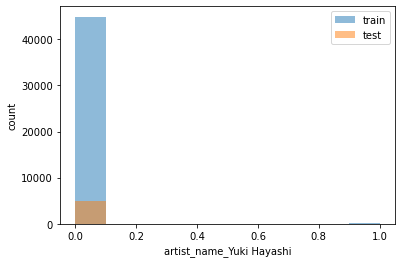

In [32]:
col = train_set.columns
col
# select the covariate(s) you want to compare
for i in col :
    covariate = i
    # create histograms for the covariate in both datasets
    plt.hist(train_set[covariate], alpha=0.5, label='train')
    plt.hist(test_set[covariate], alpha=0.5, label='test')
    plt.xlabel(covariate)
    plt.ylabel('count')
    plt.legend()
    plt.show()

In [33]:
#splitting train set and test set 
Y_train = train_set['music_genre']
X_train = train_set.drop(['music_genre'], axis=1)

Y_test = test_set['music_genre']
X_test = test_set.drop(['music_genre'], axis=1)


In [34]:
numerical_cols = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','valence']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### PCA 

pca = PCA(whiten=True)
Xpca = pca.fit_transform(X_train)

eig_vals = pca.explained_variance_
loadings = pca.components_
covar_explained = eig_vals/sum(eig_vals)*100

pca = PCA(n_components=3,whiten=True)
Xpca_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

plt.figure(figsize=(5, 5))
plt.scatter(Xpca_train[:,0], Xpca_train[:, 1],c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA with 2 components (train set)")
plt.show()

### PCA 

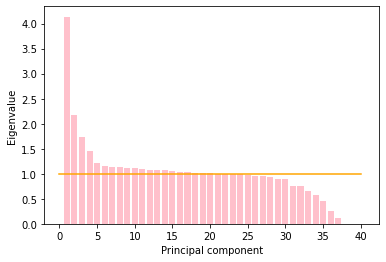

In [35]:
# 1. Z-score the data:

# 2. Initialize PCA object and fit to our data:
pca = PCA(whiten=True).fit(X_train)

# 3a. Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# 3b. Loadings (eigenvectors): Weights per factor in terms of the original data. Where do the
# principal components point, in terms of the 17 questions?
loadings = pca.components_
# 3c. Rotated Data: Simply the transformed data - we had 40 courses (rows) in
# terms of 17 variables (columns), now we have 40 courses in terms of 17
# factors ordered by decreasing eigenvalue
rotatedData = pca.fit_transform(X_train)

# 4. For the purposes of this, you can think of eigenvalues in terms of 
# (co)variance explained:
covarExplained = eigVals/sum(eigVals)*100

#Plot Screeplot 
numQuestion = X_train.shape[1]
x = np.linspace(1,numQuestion,numQuestion)
plt.bar(x, eigVals, color='pink')
plt.plot([0,numQuestion],[1,1],color='orange') # Orange Kaiser criterion line for the fox
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.show()

In [36]:

threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eigVals > threshold))
num_com =  np.count_nonzero(eigVals > threshold)

Number of factors selected by Kaiser criterion: 22


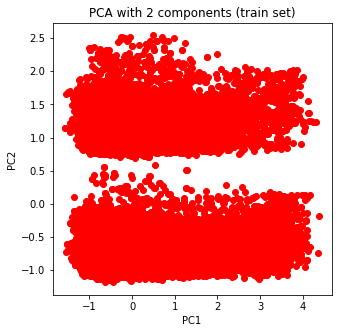

In [37]:
plt.figure(figsize=(5, 5))
plt.scatter(rotatedData[:,0], rotatedData[:, 1],c='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA with 2 components (train set)")
plt.show()

In [38]:
pca = PCA(n_components=num_com,whiten=True)
Xpca_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.10343035, 0.05453349, 0.04326362, 0.03612371, 0.03057166,
       0.02880542, 0.02852155, 0.02834283, 0.02770164, 0.02758213,
       0.02732262, 0.02701748, 0.0268006 , 0.0267402 , 0.02627018,
       0.02606326, 0.02591082, 0.02520438, 0.02517103, 0.02505601,
       0.02500962, 0.02493976])

/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/y

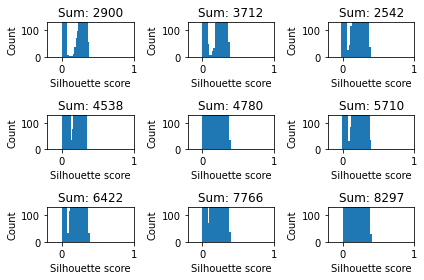

In [39]:
# Silhouette: How similar to points in cluster vs. others, arbitrariness

# Remember: each data point gets its own silhouette coefficient ranging 
# from 0 (arbitrary classification) to 1 (ideal classification).
x=rotatedData
# Init:
numClusters = 9 # how many clusters are we looping over? (from 8 to 17)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums

# Compute kMeans:
for ii in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(ii)).fit(x) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(x,cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3,3,ii-1) 
    plt.hist(s,bins=20) 
    plt.xlim(-0.2,1)
    plt.ylim(0,130)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('Sum: {}'.format(int(Q[ii-2]))) # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

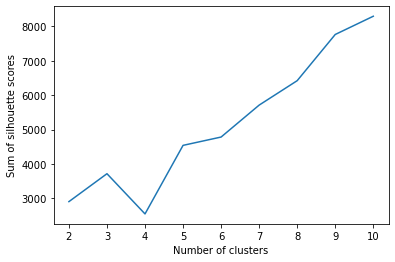

In [40]:
# Plot this to make it clearer what is going on
plt.plot(np.linspace(2,10,9),Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


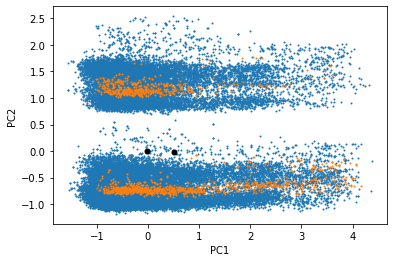

In [41]:
# Now let's recompute the kMeans using  clusters and plot the color-coded data

# Recompute kMeans:
numClusters = 4
kMeans = KMeans(n_clusters = numClusters).fit(x) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

# Plot the color-coded data:
for ii in range(numClusters):
    plotIndex = np.argwhere(cId == int(ii))
    plt.plot(x[plotIndex,0],x[plotIndex,1],'o',markersize=1)
    plt.plot(cCoords[int(ii-1),0],cCoords[int(ii-1),1],'o',markersize=5,color='black')  
    plt.xlabel('PC1')
    plt.ylabel('PC2')


### Clustering 

/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


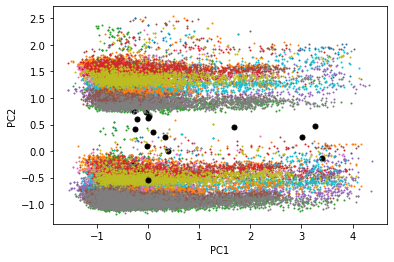

In [42]:
# Now let's recompute the kMeans using  clusters and plot the color-coded data
Xpca_train = rotatedData
x = Xpca_train

# Recompute kMeans:
numClusters = 20
kMeans = KMeans(n_clusters = numClusters).fit(x) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

# Plot the color-coded data:
for ii in range(numClusters):
    plotIndex = np.argwhere(cId == int(ii))
    plt.plot(x[plotIndex,0],x[plotIndex,1],'o',markersize=1)
    plt.plot(cCoords[int(ii-1),0],cCoords[int(ii-1),1],'o',markersize=5,color='black')  
    plt.xlabel('PC1')
    plt.ylabel('PC2')


### MODEL 

In [43]:
import time

### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

AUC score: 0.9172732


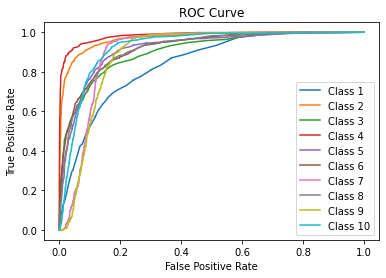

In [50]:
#Models : SVM, Decision Trees, Random Forests, Boosting methods, Neural Networks 

#Use Random Forest : 
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, criterion='gini')

# Fit the model to the training data
rf.fit(X_train, Y_train)

# Predict probabilities on the test data
y_proba = rf.predict_proba(X_test)

# Calculate the AUC score using the OvR strategy
auc_score = roc_auc_score(Y_test, y_proba, multi_class='ovr')
print(f"AUC score: {auc_score}")

# Plot the ROC curves for each class
fpr = {}
tpr = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, y_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i+1}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [51]:
y_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.5506

Best Parameters: {'max_depth': 8, 'n_estimators': 500}
Best Score: 0.5679555555555555
AUC score: 0.9160062666666666


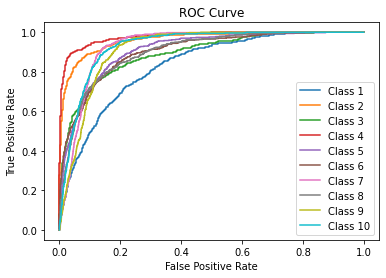

In [46]:
#Models : SVM, Decision Trees, Random Forests, Boosting methods, Neural Networks 

#Use Random Forest : 

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(criterion='gini')

#Hyperparameter Tuning : 
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth' : [4,5,7,8]
}

# Create a GridSearchCV object
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_rf.fit(X_train, Y_train)

# Get the best parameters and score
best_params = grid_rf.best_params_
print("Best Parameters:", best_params)

best_score = grid_rf.best_score_
print("Best Score:", best_score)

# Use the best parameters to create a new model
best_rf = RandomForestClassifier(**best_params)

# Fit the model to the training data
best_rf.fit(X_train, Y_train)

# Predict probabilities on the test data
y_proba = best_rf.predict_proba(X_test)


# Calculate the AUC score using the OvR strategy
auc_score = roc_auc_score(Y_test, y_proba, multi_class='ovr')
print(f"AUC score: {auc_score}")

# Plot the ROC curves for each class
fpr = {}
tpr = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, y_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i+1}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [47]:
# Make predictions on the testing data
y_pred = best_rf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5514


In [67]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression(multi_class='ovr')  # multiclass='ovr' for one-vs-rest strategy

# Train the model
model.fit(X_train, Y_train)

# Predict probabilities for each class on the testing set
y_pred_prob = model.predict_proba(X_test)

# Compute the AUC score for each class
auc_scores = roc_auc_score(Y_test, y_pred_prob, average=None,multi_class='ovr')

# Compute the micro-average AUC score
auc_micro = roc_auc_score(Y_test, y_pred_prob, average='micro',multi_class='ovr')

# Compute the macro-average AUC score
auc_macro = roc_auc_score(Y_test, y_pred_prob, average='macro',multi_class='ovr')

# Print the AUC scores
print("AUC Scores for Each Class:", auc_scores)
print("Micro-Average AUC Score:", auc_micro)
print("Macro-Average AUC Score:", auc_macro)



AUC Scores for Each Class: [0.80362178 0.93671289 0.86718533 0.97397956 0.882958   0.88933889
 0.92283267 0.86045889 0.91224956 0.91726778]
Micro-Average AUC Score: 0.9036649022222223
Macro-Average AUC Score: 0.8966605333333334


In [68]:
# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, y_proba[:, i])
    roc_auc[i] = roc_auc_score(Y_test == i, y_proba[:, i])

AUC score: 0.9172732


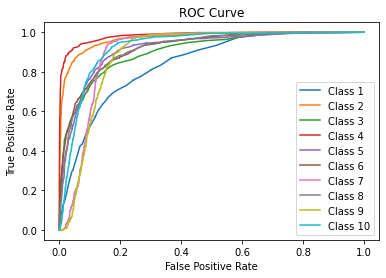

In [69]:
# Calculate the AUC score using the OvR strategy
auc_score = roc_auc_score(Y_test, y_proba, multi_class='ovr')
print(f"AUC score: {auc_score}")
# Plot the ROC curves for each class
fpr = {}
tpr = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, y_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i+1}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Extra Credit 

In [78]:
df = pd.read_csv("musicData.csv")
df = df.dropna(how='all')
df

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


In [88]:
cardi = df[df['artist_name']=='Cardi B']
cardi 

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
25185,34498.0,Cardi B,Hectic (feat. DJ Hardwerk),56.0,0.78200,0.718,172584.0,0.715,0.000006,G,0.1400,-3.449,Major,0.330,89.088,4-Apr,0.616,Rap
25292,56833.0,Cardi B,Cheap Ass Weave,58.0,0.03830,0.782,168150.0,0.539,0.000003,D,0.3000,-8.665,Major,0.407,130.33700000000002,4-Apr,0.652,Rap
25433,22255.0,Cardi B,Trust Issues,57.0,0.07780,0.785,144483.0,0.548,0.000000,D,0.3680,-8.254,Major,0.283,107.844,4-Apr,0.375,Rap
26018,21682.0,Cardi B,Back It Up (feat. Konshens & Hoodcelebrityy),59.0,0.01580,0.703,157613.0,0.594,0.000019,G,0.0802,-6.996,Major,0.268,123.234,5-Apr,0.451,Rap
26561,75889.0,Cardi B,Get Up 10,71.0,0.09770,0.806,231453.0,0.570,0.000000,C#,0.1050,-6.927,Major,0.246,93.015,4-Apr,0.454,Rap
27252,87037.0,Cardi B,Thru Your Phone,73.0,0.17000,0.837,-1.0,0.549,0.000000,C,0.0570,-5.722,Major,0.167,121.954,4-Apr,0.209,Rap
27482,90883.0,Cardi B,I Like It - Dillon Francis Remix,70.0,0.00256,0.731,-1.0,0.854,0.000015,F,0.3860,-4.635,Minor,0.149,150.16299999999998,4-Apr,0.651,Rap
27801,37617.0,Cardi B,Bodak Yellow,81.0,0.06590,0.926,223713.0,0.703,0.000000,B,0.2310,-6.337,Minor,0.103,125.022,4-Apr,0.485,Rap
28023,57255.0,Cardi B,Money,89.0,0.00534,0.950,183527.0,0.590,0.000000,G#,0.1100,-6.508,Minor,0.290,130.003,4-Apr,0.219,Rap
28151,63533.0,Cardi B,I Like It,90.0,0.09900,0.816,253390.0,0.726,0.000000,F,0.3720,-3.998,Minor,0.129,136.048,4-Apr,0.650,Rap


/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Hectic (feat. DJ Hardwerk)'),
  Text(1, 0, 'Cheap Ass Weave'),
  Text(2, 0, 'Trust Issues'),
  Text(3, 0, 'Back It Up (feat. Konshens & Hoodcelebrityy)'),
  Text(4, 0, 'Get Up 10'),
  Text(5, 0, 'Thru Your Phone'),
  Text(6, 0, 'I Like It - Dillon Francis Remix'),
  Text(7, 0, 'Bodak Yellow'),
  Text(8, 0, 'Money'),
  Text(9, 0, 'I Like It'),
  Text(10, 0, 'Lit Thot'),
  Text(11, 0, 'Foreva'),
  Text(12, 0, 'Pull Up'),
  Text(13, 0, 'Ring (feat. Kehlani)'),
  Text(14, 0, 'Be Careful'),
  Text(15, 0, 'Lick (feat. Offset)'),
  Text(16, 0, 'Bronx Season')])

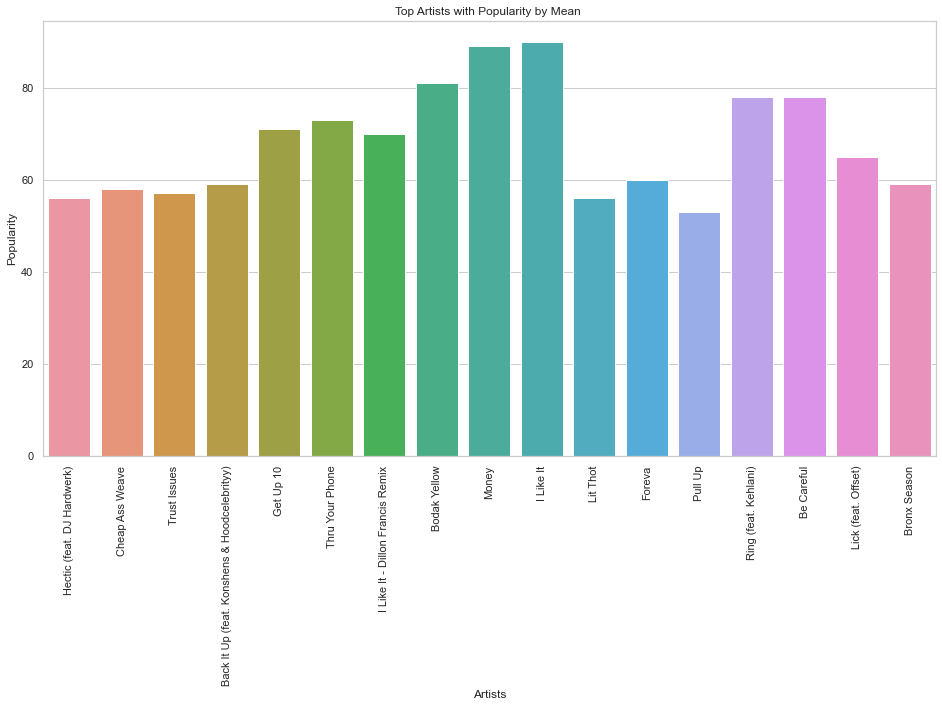

In [95]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
x = cardi["popularity"].sort_values(ascending=False).head(20)
ax = sns.barplot(cardi['track_name'], x)
ax.set_title('Top Artists with Popularity by Mean ')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

In [104]:
doja = df[df['artist_name']=='Doja Cat']
doja 

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
16088,66143.0,Doja Cat,Tia Tamera (feat. Rico Nasty),65.0,0.01700,0.814,212813.0,0.675,0.000000,C,0.182,-4.594,Major,0.0931,119.867,4-Apr,0.407,Alternative
16298,87432.0,Doja Cat,Wine Pon You (feat. Konshens),44.0,0.30400,0.797,218973.0,0.444,0.001260,A,0.107,-7.738,Minor,0.0411,95.035,4-Apr,0.138,Alternative
16702,42842.0,Doja Cat,Body Language,45.0,0.27700,0.717,245240.0,0.468,0.000000,G#,0.112,-7.077,Major,0.0525,96.47,4-Apr,0.691,Alternative
16766,31493.0,Doja Cat,Candy,54.0,0.51300,0.689,190920.0,0.516,0.000000,G#,0.163,-5.857,Major,0.0444,124.876,4-Apr,0.209,Alternative
17576,36681.0,Doja Cat,Fancy,46.0,0.07260,0.747,179200.0,0.734,0.000000,D,0.131,-5.781,Major,0.0361,110.978,4-Apr,0.153,Alternative
18724,91202.0,Doja Cat,No Police,52.0,0.76900,0.590,240427.0,0.331,0.005440,A,0.185,-9.986,Major,0.0609,120.06200000000001,4-Apr,0.292,Alternative
18911,26261.0,Doja Cat,Wild Beach,44.0,0.25100,0.713,204360.0,0.675,0.000722,E,0.117,-6.519,Minor,0.0654,120.04799999999999,4-Apr,0.379,Alternative
19296,33481.0,Doja Cat,Roll With Us,49.0,0.00434,0.664,-1.0,0.637,0.000005,D,0.199,-5.593,Major,0.0283,121.975,4-Apr,0.125,Alternative
19814,25069.0,Doja Cat,Go To Town,64.0,0.07160,0.710,217813.0,0.710,0.000001,C,0.206,-2.474,Major,0.0579,169.94400000000002,4-Apr,0.700,Alternative


/Users/yenle/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Tia Tamera (feat. Rico Nasty)'),
  Text(1, 0, 'Wine Pon You (feat. Konshens)'),
  Text(2, 0, 'Body Language'),
  Text(3, 0, 'Candy'),
  Text(4, 0, 'Fancy'),
  Text(5, 0, 'No Police'),
  Text(6, 0, 'Wild Beach'),
  Text(7, 0, 'Roll With Us'),
  Text(8, 0, 'Go To Town')])

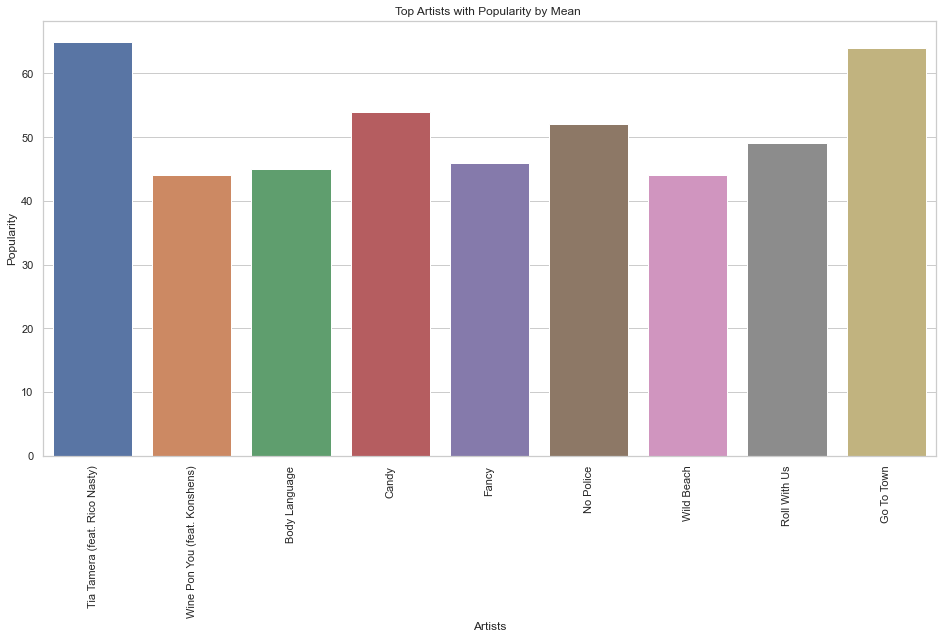

In [108]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
x = doja["popularity"].sort_values(ascending=False).head(20)
ax = sns.barplot(doja['track_name'], x)
ax.set_title('Top Artists with Popularity by Mean ')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)